In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="price_match_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation__discount.sample import sample_discount_customers
from ml_simulation__discount.data import get_discount_compute_function
from ml_simulation__discount.widget import show_discount_widget
from ml_simulation__discount.graph import show_discount_comparison_graph
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')

assert len(df_quotes['id_devis'].unique()) == len(df_quotes)

df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = split_result['simulation']

TRAIN = False
MODEL_NAME = "simulation_poc_discount"

# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, MODEL_NAME)
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open(f'{MODEL_NAME}.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']

# Check what features your current model expects
print(f"Model expects {len(feature_names)} features")
print(f"Sample features: {feature_names[:10]}")
print(f"'season_summer' in features: {'season_summer' in feature_names}")


# Sampling
sample_seed = int(time.time() * 1000) % 10000000
selected_ids = sample_discount_customers(df_sim, random_state=sample_seed)

# Simulation
compute = get_discount_compute_function(model, feature_names, df_sim, selected_ids)
show_discount_widget(compute, selected_ids)


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers
Model expects 192 features
Sample features: ['std_days_between_quotes', 'price_trajectory', 'unique_product_families', 'product_consistency', 'avg_discount_pct', 'main_agency', 'main_region', 'total_historical_quotes', 'had_historical_quotes', 'avg_days_since_first_quote']
'season_summer' in features: True
Non-converted customers: 923
Candidates with price data: 923

📊 SAMPLING STRATEGY:
   1. No existing discount (test introduction)
   2. Small existing discount (< 2%)
   3. Medium existing discount (2-5%)
   4. High price (>€20k)
   5. Multiple quotes (≥3)
✓ Sampled no-discount: CL00340887
✓ Sampled small-discount: CL00315072
✓ Sampled medium-discount: CL00312079
✓ Sampled high-price: CL00339050
✓ Sampled multi-quote: CL00339703

🎯 SELECTED 5 DISCOUNT CUSTOMERS:
customer_id  quote_count  total_price  discount_pct
 CL00340887            2      4990.39      0.000000
 CL00315072            3

  customer_id  base_prediction  new_prediction  discount_pct  discount_amount
0  CL00312079         0.633441        0.633441           0.0              0.0
1  CL00315072         0.291255        0.291255           0.0              0.0
2  CL00339050         0.183293        0.183293           0.0              0.0
3  CL00339703         0.251557        0.251557           0.0              0.0
4  CL00340887         0.412428        0.412428           0.0              0.0
  customer_id  base_prediction  new_prediction  discount_pct  discount_amount
0  CL00312079         0.633441        0.633441           0.0              0.0
1  CL00315072         0.291255        0.291255           0.0              0.0
2  CL00339050         0.183293        0.183293           0.0              0.0
3  CL00339703         0.251557        0.251557           0.0              0.0
4  CL00340887         0.412428        0.412428           0.0              0.0


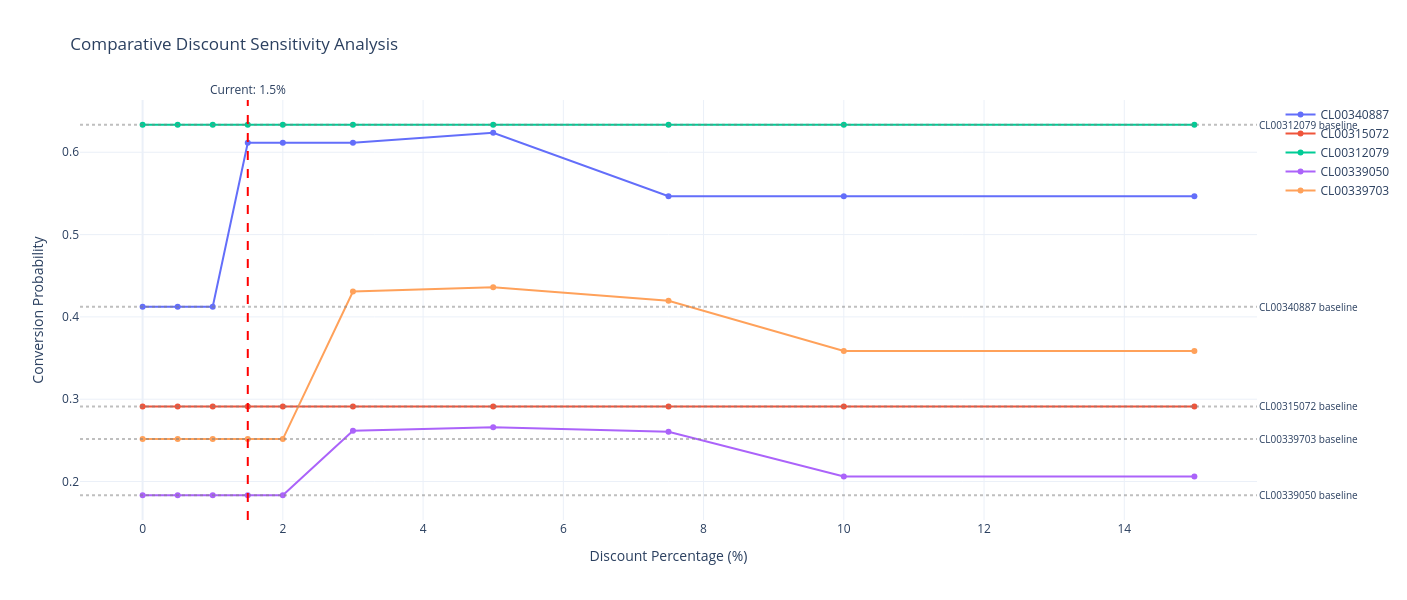

✓ Comparative discount response curves created!
✓ Hover over any point to see customer-specific details
✓ Each line shows a different customer's sensitivity to discounts


In [3]:
show_discount_comparison_graph(df_sim, model, selected_ids)